### Face completion

You get the left half of a face image. Predict the right one.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces().images

downloading Olivetti faces from http://cs.nyu.edu/~roweis/data/olivettifaces.mat to /Users/Kes/scikit_learn_data


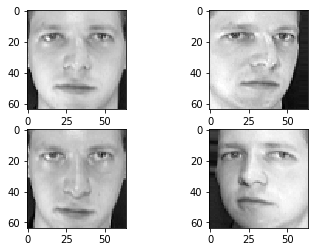

In [2]:
#Yet another matplotlib feature - subplot - creates a grid-like structure of plots
#Syntax: plt.subplot(width,height,index) with index starting from 1.
plt.subplot(2,2,1)
plt.imshow(data[0],cmap='gray')
plt.subplot(2,2,2)
plt.imshow(data[1],cmap='gray')
plt.subplot(2,2,3)
plt.imshow(data[2],cmap='gray')
plt.subplot(2,2,4)
plt.imshow(data[3],cmap='gray')

# X,y

We now must slice the data into known part "X" and unknown part "y". Since data is just a numpy array, you can slice it with multi-dimensional slices.

The dimensions are (image_index, height, width).

* `data[:10]` - first 10 images
* `data[:, :10]` - 10-pixel stripe at the top of each image.
* `data[10:20, :, :10]` - take images 10-19 and slice __horizontally__ a stripe of width 10 pixels

Let's now use that to slice our data.


In [13]:
X=data[:,:, :data.shape[2]/2]
y=data[:,:, data.shape[2]/2:]
data.shape

(400, 64, 64)

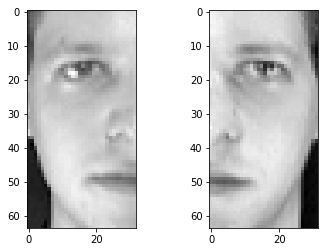

In [14]:
#If you did everything right, you should see two half-faces composing a face
plt.subplot(1,2,1)
plt.imshow(X[0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y[0],cmap='gray')


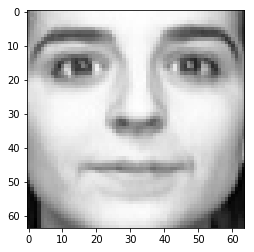

In [17]:
def glue(left_half,right_half):
    #melt two half-faces back into a face
    left_half = left_half.reshape([-1,64,32])
    right_half = right_half.reshape([-1,64,32])
    return np.concatenate([left_half,right_half],axis=-1)


plt.imshow(glue(X,y)[99],cmap='gray')

# Linear Regression

Now let's get through the usual pipeline: split data between train and test; fit linear regression

In [18]:
from sklearn.cross_validation import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X.reshape([len(X),-1]),
                                                 y.reshape([len(y),-1]),
                                                 test_size=0.05,random_state=42)
print("X_train.shape=",X_train.shape)
print("X_test.shape=",X_test.shape)


X_train.shape= (380, 2048)
X_test.shape= (20, 2048)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(Y_train,model.predict(X_train)))
print(mean_squared_error(Y_test,model.predict(X_test)))

3.09197138558e-12
0.0102840175389


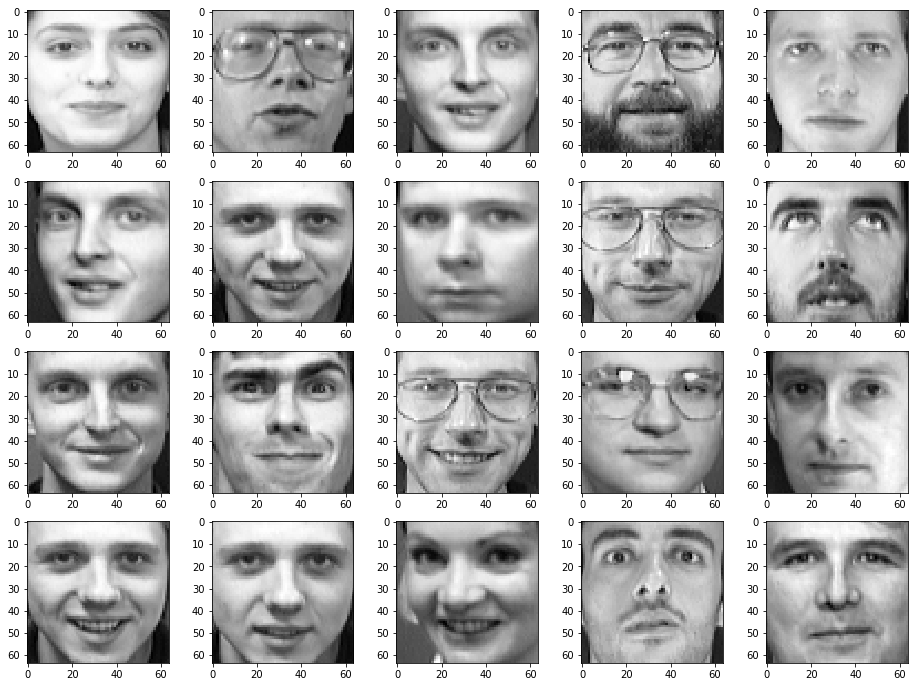

In [24]:
#Images restored on the training settrain

predictions = model.predict(X_train)

pics = glue(X_train,predictions)
plt.figure(figsize=[16,12])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(pics[i],cmap='gray')

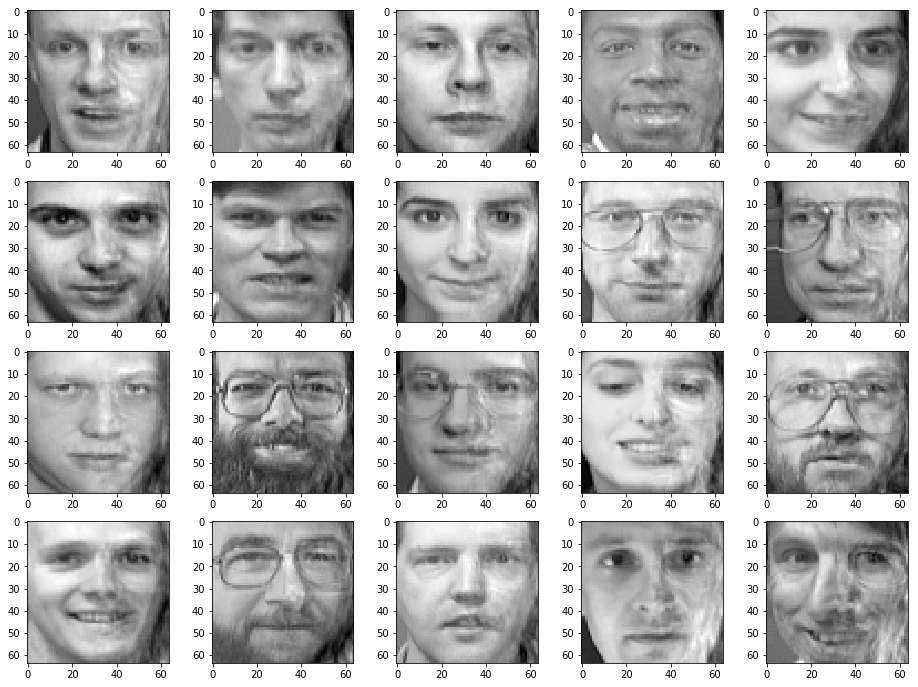

In [25]:
#Images from test restored
predictions = model.predict(X_test)

pics = glue(X_test,predictions)
plt.figure(figsize=[16,12])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(pics[i],cmap='gray')

# Ridge regression

Ridge regression is a simple linear regression with L2 penalty: $ argmin \space L + \alpha \cdot \sum_i W_i^2 $


In [27]:
from sklearn.linear_model import Ridge
#Example syntax: Ridge(alpha=0.5), just like LinearRegression


Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [39]:
model_r = Ridge(alpha=0.01)
model_r.fit(X_train,Y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [40]:
print(mean_squared_error(Y_train,model_r.predict(X_train)))
print(mean_squared_error(Y_test,model_r.predict(X_test)))

8.28606081633e-07
0.0101372500015


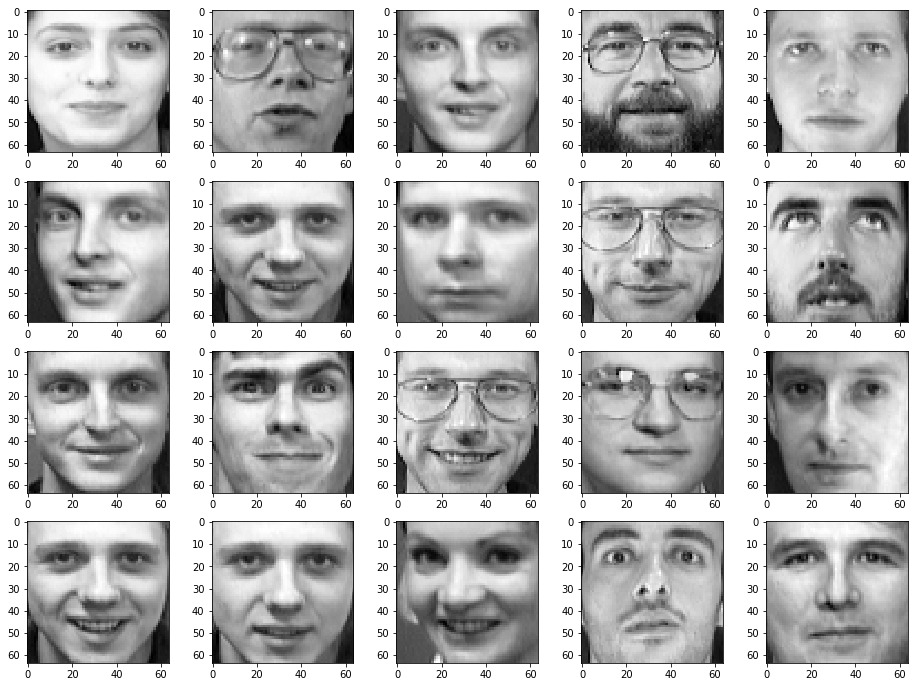

In [36]:
#Images from test restored
predictions = model_r.predict(X_train)

pics = glue(X_train,predictions)
plt.figure(figsize=[16,12])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(pics[i],cmap='gray')

# Bonus: Grid search

Find alpha that minimizes test error. You can do so by enumerating all alphas in a reasonable diapason using loops.

In [41]:
import numpy as np
from scipy.optimize import minimize

In [46]:
def ridge_alpha(x):
    model_r = Ridge(alpha=x)
    model_r.fit(X_train,Y_train)
    return mean_squared_error(Y_test,model_r.predict(X_test))

In [47]:
x0 = np.array([1, 0.1, 0.01, 0.001, 1e-4])
res = minimize(ridge_alpha, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

ValueError: Number of targets and number of penalties do not correspond: 5 != 2048